In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Library

In [2]:
import numpy as np 
import pandas as pd
import re
import spacy
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Read Data

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Learning Style Classification/dataset.csv")

In [4]:
df.head()

,Sentence,Type
0,"Ali, who was two at the time, loved the story ...",Auditory
1,"Look at my dad, spiffed up in jodhpurs, ready ...",Auditory
2,Believe me it's far more difficult to know wha...,Auditory
3,"The Surrealists loved bad movies, seeing them ...",Auditory
4,"He idolised prize-fighters, regarded racketeer...",Auditory


In [5]:
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns')

There are 15450 rows and 2 columns


In [6]:
df.describe()

,Sentence,Type
count,15450,15450
unique,14594,3
top,Show More Sentences,Visual
freq,667,5827


In [7]:
temp = df.groupby('Type').count()['Sentence'].reset_index().sort_values(by='Sentence',ascending=False)
temp.style.background_gradient(cmap='Purples')

,Type,Sentence
2,Visual,5827
1,Kinesthetic,4819
0,Auditory,4804


# Data Cleaning

In [8]:
df.isnull().sum()

Sentence    0
Type        0
dtype: int64

In [9]:
df['Sentence'].duplicated().sum()

856

In [10]:
duplicateRows = df[df.duplicated()]

In [11]:
duplicateRows

,Sentence,Type
297,Show More Sentences,Visual
318,Show More Sentences,Visual
339,Show More Sentences,Visual
360,Show More Sentences,Visual
381,Show More Sentences,Visual
...,...,...
15345,Show More Sentences,Kinesthetic
15366,Show More Sentences,Kinesthetic
15387,Show More Sentences,Kinesthetic
15408,Show More Sentences,Kinesthetic


In [12]:
df.drop_duplicates(inplace=True,keep=False)
df.shape

(14595, 2)

In [13]:
temp = df.groupby('Type').count()['Sentence'].reset_index().sort_values(by='Sentence',ascending=False)
temp.style.background_gradient(cmap='Purples')

,Type,Sentence
2,Visual,5527
1,Kinesthetic,4572
0,Auditory,4496


In [14]:
df.head()

,Sentence,Type
0,"Ali, who was two at the time, loved the story ...",Auditory
1,"Look at my dad, spiffed up in jodhpurs, ready ...",Auditory
2,Believe me it's far more difficult to know wha...,Auditory
3,"The Surrealists loved bad movies, seeing them ...",Auditory
4,"He idolised prize-fighters, regarded racketeer...",Auditory


In [15]:
nlp = spacy.load('en_core_web_sm')

In [16]:
df['Sentence_modified'] = df['Sentence'].apply(lambda x: [doc.lemma_ for doc in  nlp(x) if not doc.is_stop])
df['Sentence_modified'] = df['Sentence_modified'].apply(lambda x: " ".join(x))

In [17]:
df.head()

,Sentence,Type,Sentence_modified
0,"Ali, who was two at the time, loved the story ...",Auditory,"Ali , time , love story little girl live teeny..."
1,"Look at my dad, spiffed up in jodhpurs, ready ...",Auditory,"look dad , spiffe jodhpur , ready ride bay mar..."
2,Believe me it's far more difficult to know wha...,Auditory,believe far difficult know unconscious love mo...
3,"The Surrealists loved bad movies, seeing them ...",Auditory,"Surrealists love bad movie , see subversive at..."
4,"He idolised prize-fighters, regarded racketeer...",Auditory,"idolise prize - fighter , regard racketeer fri..."


In [18]:
def clean_text(text):
    text = re.sub(r"https?://\w+\.\w+\.\w+", "", text).lower()
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = text.replace(".", " " )
    text = text.replace(",", " " )
    text = text.replace("-", " " )
    text = text.replace(r'\s+', ' ')
    return text

In [19]:
df['Sentence_modified'] = df['Sentence_modified'].apply(clean_text)
df.head()

,Sentence,Type,Sentence_modified
0,"Ali, who was two at the time, loved the story ...",Auditory,ali time love story little girl live teeny...
1,"Look at my dad, spiffed up in jodhpurs, ready ...",Auditory,look dad spiffe jodhpur ready ride bay mar...
2,Believe me it's far more difficult to know wha...,Auditory,believe far difficult know unconscious love mo...
3,"The Surrealists loved bad movies, seeing them ...",Auditory,surrealists love bad movie see subversive at...
4,"He idolised prize-fighters, regarded racketeer...",Auditory,idolise prize fighter regard racketeer fri...


# Exploration Data Analysis

In [20]:
df_Auditory = df[df['Type'] == 'Auditory']
df_Visual = df[df['Type'] == 'Visual']
df_Kinesthetic = df[df['Type'] == 'Kinesthetic']

In [21]:
all_most_frequent_world = Counter(" ".join(df["Sentence_modified"]).split()).most_common(50)
all_most_frequent_world

[('try', 614),
 ('sound', 577),
 ('time', 534),
 ('hear', 530),
 ('like', 505),
 ('voice', 446),
 ('hold', 435),
 ('people', 412),
 ('idea', 378),
 ('motion', 366),
 ('picture', 365),
 ('noise', 358),
 ('listen', 346),
 ('vision', 344),
 ('focus', 343),
 ('loud', 342),
 ('love', 338),
 ('dream', 338),
 ('pressure', 338),
 ('look', 334),
 ('work', 330),
 ('tone', 329),
 ('come', 327),
 ('silence', 325),
 ('imagine', 322),
 ('observe', 321),
 ('horizon', 319),
 ('tie', 319),
 ('emotional', 318),
 ('discuss', 318),
 ('notice', 318),
 ('speak', 317),
 ('grip', 312),
 ('obvious', 311),
 ('sensitive', 311),
 ('illusion', 307),
 ('illustrate', 304),
 ('clarity', 302),
 ('new', 293),
 ('give', 291),
 ('year', 285),
 ('softly', 285),
 ('feel', 283),
 ('view', 282),
 ('shift', 277),
 ('watch', 276),
 ('way', 275),
 ('take', 274),
 ('talk', 270),
 ('man', 265)]

In [22]:
Auditory_most_frequent_world = Counter(" ".join(df_Auditory["Sentence_modified"]).split()).most_common(50)
Auditory_most_frequent_world

[('sound', 490),
 ('hear', 469),
 ('voice', 397),
 ('noise', 345),
 ('loud', 337),
 ('listen', 325),
 ('tone', 318),
 ('silence', 314),
 ('discuss', 305),
 ('love', 263),
 ('speak', 244),
 ('talk', 217),
 ('like', 196),
 ('audible', 173),
 ('shrill', 168),
 ('time', 164),
 ('people', 145),
 ('tell', 128),
 ('come', 126),
 ('music', 125),
 ('articulate', 123),
 ('word', 120),
 ('screech', 110),
 ('know', 109),
 ('new', 107),
 ('converse', 99),
 ('man', 96),
 ('go', 95),
 ('pronounce', 89),
 ('say', 87),
 ('language', 87),
 ('shout', 85),
 ('think', 81),
 ('work', 80),
 ('want', 79),
 ('radio', 79),
 ('long', 77),
 ('find', 74),
 ('good', 74),
 ('year', 73),
 ('way', 72),
 ('give', 72),
 ('court', 71),
 ('high', 69),
 ('film', 68),
 ('try', 67),
 ('play', 66),
 ('set', 64),
 ('squeal', 64),
 ('feel', 62)]

In [23]:
Visual_most_frequent_world = Counter(" ".join(df_Visual["Sentence_modified"]).split()).most_common(50)
Visual_most_frequent_world

[('idea', 329),
 ('vision', 327),
 ('focus', 321),
 ('dream', 320),
 ('picture', 318),
 ('horizon', 316),
 ('notice', 311),
 ('imagine', 308),
 ('observe', 308),
 ('obvious', 305),
 ('illusion', 305),
 ('clarity', 302),
 ('illustrate', 302),
 ('view', 237),
 ('look', 216),
 ('watch', 208),
 ('scope', 206),
 ('time', 204),
 ('inspect', 178),
 ('like', 173),
 ('give', 153),
 ('analyze', 151),
 ('work', 151),
 ('conspicuous', 147),
 ('people', 146),
 ('appear', 130),
 ('new', 126),
 ('sight', 124),
 ('come', 118),
 ('take', 118),
 ('create', 118),
 ('year', 117),
 ('way', 116),
 ('good', 113),
 ('world', 110),
 ('great', 104),
 ('use', 104),
 ('day', 103),
 ('long', 102),
 ('line', 99),
 ('life', 97),
 ('eye', 95),
 ('point', 95),
 ('go', 87),
 ('envision', 85),
 ('man', 84),
 ('light', 80),
 ('study', 77),
 ('say', 76),
 ('include', 74)]

In [24]:
Kinesthetic_most_frequent_world = Counter(" ".join(df_Kinesthetic["Sentence_modified"]).split()).most_common(50)
Kinesthetic_most_frequent_world

[('try', 489),
 ('hold', 349),
 ('motion', 327),
 ('pressure', 322),
 ('grip', 310),
 ('tie', 309),
 ('emotional', 305),
 ('sensitive', 302),
 ('softly', 281),
 ('shift', 250),
 ('stress', 199),
 ('feel', 189),
 ('feeling', 187),
 ('support', 168),
 ('active', 166),
 ('time', 166),
 ('intuition', 154),
 ('hang', 144),
 ('like', 136),
 ('hassle', 123),
 ('people', 121),
 ('water', 116),
 ('high', 105),
 ('work', 99),
 ('take', 96),
 ('year', 95),
 ('stir', 94),
 ('life', 90),
 ('hand', 88),
 ('way', 87),
 ('hustle', 87),
 ('man', 85),
 ('find', 85),
 ('come', 83),
 ('callous', 83),
 ('long', 81),
 ('cause', 80),
 ('change', 79),
 ('go', 76),
 ('good', 75),
 ('know', 75),
 ('increase', 74),
 ('leave', 70),
 ('use', 69),
 ('place', 68),
 ('result', 67),
 ('give', 66),
 ('right', 66),
 ('hunch', 66),
 ('day', 65)]

In [25]:
# to list of world
all_most_frequent_world = [list(ele)[0] for ele in all_most_frequent_world]
Auditory_most_frequent_world = [list(ele)[0] for ele in Auditory_most_frequent_world]
Visual_most_frequent_world = [list(ele)[0] for ele in Visual_most_frequent_world]
Kinesthetic_most_frequent_world = [list(ele)[0] for ele in Kinesthetic_most_frequent_world]

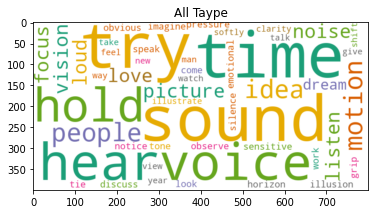

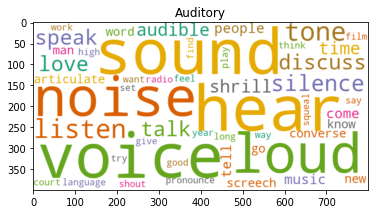

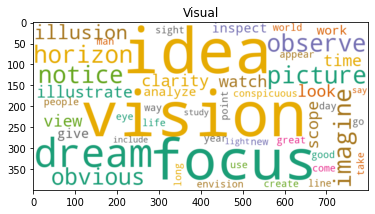

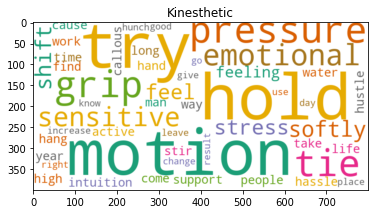

In [26]:
wordcloud = WordCloud(background_color='white',colormap='Dark2', max_font_size=150, random_state=42,width=800, height=400).generate(" ".join(all_most_frequent_world))
plt.title("All Taype")
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

wordcloud = WordCloud(background_color='white',colormap='Dark2', max_font_size=150, random_state=42,width=800, height=400).generate(" ".join(Auditory_most_frequent_world))
plt.title("Auditory")
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

wordcloud = WordCloud(background_color='white',colormap='Dark2', max_font_size=150, random_state=42,width=800, height=400).generate(" ".join(Visual_most_frequent_world))
plt.title("Visual")
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

wordcloud = WordCloud(background_color='white',colormap='Dark2', max_font_size=150, random_state=42,width=800, height=400).generate(" ".join(Kinesthetic_most_frequent_world))
plt.title("Kinesthetic")
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

# Feature And Target

In [27]:
X = df['Sentence_modified']
y = df['Type']

label_enc = LabelEncoder()
y = label_enc.fit_transform(y)
y = to_categorical(y)

In [28]:
X.shape

(14595,)

In [29]:
X[:3]

0    ali   time   love story little girl live teeny...
1    look dad   spiffe jodhpur   ready ride bay mar...
2    believe far difficult know unconscious love mo...
Name: Sentence_modified, dtype: object

In [30]:
print(label_enc.transform(label_enc.classes_))
print(list(label_enc.classes_))

[0 1 2]
['Auditory', 'Kinesthetic', 'Visual']


In [31]:
y.shape

(14595, 3)

In [32]:
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

# Document To Vector

Data Preprocessing (Doc2Vec)

In [33]:
tqdm.pandas(desc="progress-bar")

def label_sentences(StudentSentence, label_type):
    labeled = []
    for i, v in enumerate(StudentSentence):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled 

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [35]:
all_data[0:2]

[TaggedDocument(words=['seven', 'hour', 'later', 'pacific', 'ocean', 'screenwriter', 'notice', 'fellow', 'passenger', 'begin', 'morph', 'strangely', 'voldemortian', 'way'], tags=['Train_0']),
 TaggedDocument(words=['sun', 'dip', 'horizon', 'early', 'warm', 'night', 'end', 'september', 'carnival', 'stay', 'busy', 'closing', 'o', 'clock'], tags=['Train_1'])]

In [36]:
model_dbow = Doc2Vec(dm=0, vector_size=50, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 14595/14595 [00:00<00:00, 1986045.06it/s]


In [37]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 50, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 50, 'Test')

In [38]:
train_vectors_dbow.shape

(10216, 50)

In [39]:
test_vectors_dbow.shape

(4379, 50)

In [40]:
y_test.shape

(4379, 3)

In [41]:
test_vectors_dbow[:1]

array([[-0.14633965, -0.43388465,  0.24369755, -0.22644043, -0.63566899,
        -0.4099493 , -0.12701161,  0.20691636, -0.60693043, -0.0647269 ,
         0.67007494, -0.26531476, -0.33375904,  0.13739234, -0.12351004,
         0.47256121, -0.42967221,  0.25681823,  0.49719355,  0.57893217,
         0.52377665,  0.23201153,  0.61769384,  0.0782717 , -0.25730196,
         0.95566809,  0.22688137,  0.46193242, -0.05663374, -0.30464643,
         0.37000406,  0.29904684,  0.70349032,  0.08017831, -0.37670982,
        -0.5116232 ,  0.57242721, -0.07003096, -0.25863728,  0.96595371,
        -0.67545688,  0.34098506,  0.69306684,  0.59237391, -0.15121174,
        -0.13079113, -0.16104865, -0.33403146, -0.92241901,  0.03880658]])

Build And Feed The Model (Doc2Vec)

In [42]:
Early_stoping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True,
)

In [43]:
model_1 = tf.keras.models.Sequential([tf.keras.layers.Input((50,1)),
                                    tf.keras.layers.Bidirectional(CuDNNLSTM(128, return_sequences=True)),
                                    tf.keras.layers.GlobalMaxPool1D(),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(32, activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(3, activation='softmax')])
                    

model_1.compile(loss='categorical_crossentropy', 
              optimizer= tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [44]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 50, 256)          134144    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2

In [45]:
history_1 = model_1.fit(train_vectors_dbow,
          y_train,
          validation_data=(test_vectors_dbow, y_test),
          batch_size=64,
          epochs=100,
          callbacks=[Early_stoping])

Epoch 1/100
160/160 [==============================] - 7s 13ms/step - loss: 1.0817 - accuracy: 0.4037 - val_loss: 1.0606 - val_accuracy: 0.4334
Epoch 2/100
160/160 [==============================] - 2s 10ms/step - loss: 1.0450 - accuracy: 0.4599 - val_loss: 1.0479 - val_accuracy: 0.4770
Epoch 3/100
160/160 [==============================] - 2s 10ms/step - loss: 1.0175 - accuracy: 0.4806 - val_loss: 0.9855 - val_accuracy: 0.5175
Epoch 4/100
160/160 [==============================] - 2s 10ms/step - loss: 0.9863 - accuracy: 0.5147 - val_loss: 0.9604 - val_accuracy: 0.5351
Epoch 5/100
160/160 [==============================] - 2s 10ms/step - loss: 0.9696 - accuracy: 0.5296 - val_loss: 0.9384 - val_accuracy: 0.5561
Epoch 6/100
160/160 [==============================] - 2s 10ms/step - loss: 0.9713 - accuracy: 0.5387 - val_loss: 0.9358 - val_accuracy: 0.5554
Epoch 7/100
160/160 [==============================] - 2s 10ms/step - loss: 0.9505 - accuracy: 0.5558 - val_loss: 0.9253 - val_accuracy:

Model Evaluation (Doc2Vec)

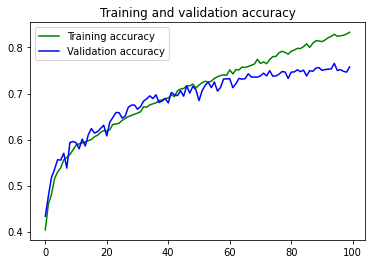

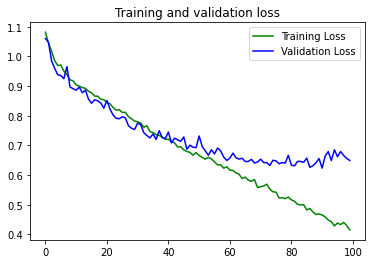

In [46]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [47]:
loss, acc=model_1.evaluate(test_vectors_dbow, y_test, verbose=1)

137/137 [==============================] - 1s 5ms/step - loss: 0.6494 - accuracy: 0.7577


In [49]:
print (f"Test Accuracy = {round(acc,2)} %")

Test Accuracy = 0.76 %


In [50]:
y_pred_1 = model_1.predict(test_vectors_dbow)
y_pred_1

137/137 [==============================] - 1s 4ms/step


array([[4.4563502e-02, 9.2220116e-01, 3.3235464e-02],
       [5.3169145e-03, 2.6078475e-01, 7.3389834e-01],
       [7.9446572e-01, 7.3931329e-02, 1.3160296e-01],
       ...,
       [4.4771736e-03, 9.9287778e-01, 2.6449698e-03],
       [9.9963236e-01, 2.2288023e-04, 1.4479324e-04],
       [9.6220863e-01, 4.6713972e-03, 3.3119887e-02]], dtype=float32)

In [51]:
y_pred_1 = np.argmax(y_pred_1, axis=1)
y_test=np.argmax(y_test, axis=1)
print(classification_report(y_test, y_pred_1, target_names=label_enc.classes_))

              precision    recall  f1-score   support

    Auditory       0.75      0.76      0.76      1399
 Kinesthetic       0.73      0.77      0.75      1358
      Visual       0.79      0.75      0.77      1622

    accuracy                           0.76      4379
   macro avg       0.76      0.76      0.76      4379
weighted avg       0.76      0.76      0.76      4379



In [52]:
model_1.save('model_Doc2Vec.h5')

# Word Embedding

Data Preprocessing (Word Embedding)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

In [54]:
# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
X_train = pad_sequences(sequences_train, maxlen=48, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=48, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary Size = {vocabSize}")

Vocabulary Size = 19331


In [55]:
X_train.shape

(10216, 48)

In [56]:
y_train.shape

(10216, 3)

In [57]:
X_test.shape

(4379, 48)

In [58]:
y_test.shape

(4379, 3)

Build And Feed The Model (Word Embedding)

In [59]:
Early_stoping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True,
)

In [60]:
model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Embedding(vocabSize, 200, input_length=X_train.shape[1]))
model_2.add(tf.keras.layers.Bidirectional(CuDNNLSTM(128, return_sequences=True)))
model_2.add(tf.keras.layers.GlobalMaxPool1D())
model_2.add(tf.keras.layers.Dropout(0.2))
model_2.add(tf.keras.layers.Dense(64, activation='relu'))
model_2.add(tf.keras.layers.Dropout(0.2))
model_2.add(tf.keras.layers.Dense(32, activation='relu'))
model_2.add(tf.keras.layers.Dropout(0.2))
model_2.add(tf.keras.layers.Dense(3, activation='softmax'))


model_2.compile(loss='categorical_crossentropy', 
              optimizer= tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [61]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 48, 200)           3866200   
                                                                 
 bidirectional_1 (Bidirectio  (None, 48, 256)          337920    
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dropout_4 (Dropout)         (None, 64)               

In [62]:
history_2 = model_2.fit(X_train,
          y_train,
          validation_data=(X_test, y_test),
          batch_size=64,
          epochs=100,
          callbacks=[Early_stoping])

Epoch 1/100
160/160 [==============================] - 4s 15ms/step - loss: 0.6057 - accuracy: 0.7140 - val_loss: 0.1266 - val_accuracy: 0.9566
Epoch 2/100
160/160 [==============================] - 2s 12ms/step - loss: 0.0902 - accuracy: 0.9742 - val_loss: 0.1434 - val_accuracy: 0.9548
Epoch 3/100
160/160 [==============================] - 2s 12ms/step - loss: 0.0472 - accuracy: 0.9888 - val_loss: 0.1725 - val_accuracy: 0.9511
Epoch 4/100
160/160 [==============================] - 2s 12ms/step - loss: 0.0375 - accuracy: 0.9914 - val_loss: 0.1855 - val_accuracy: 0.9475
Epoch 5/100
160/160 [==============================] - 2s 12ms/step - loss: 0.0302 - accuracy: 0.9914 - val_loss: 0.2082 - val_accuracy: 0.9466
Epoch 6/100
160/160 [==============================] - 2s 12ms/step - loss: 0.0270 - accuracy: 0.9926 - val_loss: 0.2091 - val_accuracy: 0.9468
Epoch 7/100
160/160 [==============================] - 2s 12ms/step - loss: 0.0190 - accuracy: 0.9938 - val_loss: 0.2155 - val_accuracy:

Model Evaluation (Word Embedding)

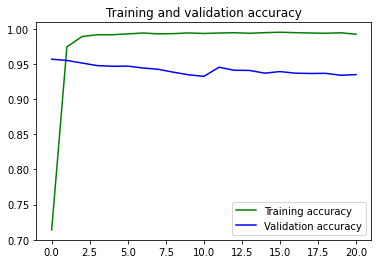

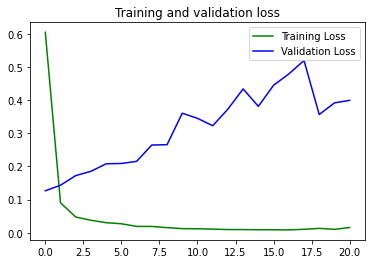

In [63]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [64]:
y_test

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [65]:
loss, acc=model_2.evaluate(X_test, y_test, verbose=1)

137/137 [==============================] - 1s 5ms/step - loss: 0.1266 - accuracy: 0.9566


In [83]:
print (f"Test Accuracy = {round(acc,2)} %")

Test Accuracy = 0.96 %


In [67]:
y_pred_2 = model_2.predict(X_test)
y_pred_2

137/137 [==============================] - 1s 4ms/step


array([[9.8666763e-01, 4.5504812e-03, 8.7818950e-03],
       [1.1030197e-03, 1.2272885e-01, 8.7616813e-01],
       [9.8007923e-01, 1.1278325e-02, 8.6425068e-03],
       ...,
       [1.7471960e-03, 9.9602240e-01, 2.2304673e-03],
       [9.9866164e-01, 2.9060119e-04, 1.0477692e-03],
       [9.9976903e-01, 4.1523548e-05, 1.8955480e-04]], dtype=float32)

In [68]:
y_pred_2 = np.argmax(y_pred_2, axis=1)
y_test=np.argmax(y_test, axis=1)
print(classification_report(y_test, y_pred_2, target_names=label_enc.classes_))

              precision    recall  f1-score   support

    Auditory       0.95      0.94      0.95      1399
 Kinesthetic       0.95      0.98      0.97      1358
      Visual       0.96      0.95      0.96      1622

    accuracy                           0.96      4379
   macro avg       0.96      0.96      0.96      4379
weighted avg       0.96      0.96      0.96      4379



In [69]:
model_2.save('model_WordEmbedding.h5')